<center><h1>Get Data on NHS Waiting Times</h1></center>

<h3>Get urls of all pages with the data</h3>

In [1]:
import requests, sys, webbrowser, bs4, os
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
from time import strptime
import matplotlib
import csv

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rc('font', size=20)

printOutput = False

os.makedirs('Bed_Data', exist_ok=True)

root_url = "https://www.england.nhs.uk/statistics/statistical-work-areas/bed-availability-and-occupancy/bed-data-overnight/"
res = requests.get(root_url)
soup = bs4.BeautifulSoup(res.content)

linkElems = soup.select("a")
page_names = []

for elem in linkElems:
    if "NHS organisations in England, Quarter" in elem.getText():
        page_names.append(elem.get('href'))
        
print("Total of {} pages found".format(len(page_names)))

Total of 46 pages found


<h2>Take data from xls files</h2>

In [2]:
attendence_months = []
over4hours_months = []
period_months = []

attendence_weeks = []
over4hours_weeks = []
period_weeks = []


# Make vectorised int function
vecint = np.vectorize(int)

# Open first data set to get all of the hospital names 
# AttendenceData = np.zeros(len())

# Gather data that we actually want to use
data = page_names
        
###########################################
### Get names and initiate data storage ###
##########################################

resp = requests.get(data[0])
# Store the data in a temporary file
tempfile = open('tempfile.xls', 'wb')
tempfile.write(resp.content)
tempfile.close()
sheet = pd.read_excel('tempfile.xls', sheet_name=0, skiprows=14, usecols="A,B,C,D,E,F,G,H,I,J,K,L,M,N")

# List of names from the first sheet
firstNames = sheet['Org Name'].values        

oldTrusts = np.array(["Bedford Hospital NHS Trust", 
                      "Luton And Dunstable University Hospital NHS Foundation Trust",
                      "Basildon And Thurrock University Hospitals NHS Foundation Trust",
                      "Mid Essex Hospital Services NHS Trust",
                      "Southend University Hospital NHS Foundation Trust",
                      "Royal Liverpool And Broadgreen University Hospitals NHS Trust",
                      "Aintree University Hospital NHS Foundation Trust",
                      "Central Manchester University Hospitals NHS Foundation Trust",
                      "University Hospital Of South Manchester NHS Foundation Trust"])

oldTrusts = [oldTrust.upper() for oldTrust in oldTrusts]


firstNames = np.concatenate((firstNames, oldTrusts))
#print(firstNames)
BedsAvail = np.zeros((len(firstNames), len(data)),dtype=object) 
BedsAvail[:,:] = '-'
OccBeds = np.zeros((len(firstNames), len(data)),dtype=object) 
OccBeds[:,:] = '-'
    
for i, name in enumerate(data):  
    #print(i, name)
    
    # Get the data location
    resp = requests.get(name)

    # Store the data in a temporary file
    tempfile = open('tempfile.xls', 'wb')
    tempfile.write(resp.content)
    tempfile.close()

    # Get all of the data from row 16 with columns A to N
    if not 'XLS-406K' in name:
        sheet_avail = pd.read_excel('tempfile.xls', sheet_name=0, skiprows=14, usecols="F,G,H,I,J,K")
        sheet_occ = pd.read_excel('tempfile.xls', sheet_name=0, skiprows=14, usecols="F,N,M,O,P,Q")
    else:
        sheet_avail = pd.read_excel('tempfile.xls', sheet_name=0, skiprows=5, usecols="E,F,G,H,I")
        sheet_occ = pd.read_excel('tempfile.xls', sheet_name=0, skiprows=5, usecols="E,L,M,N,O,P")

    #print(sheet)
    newNames = sheet_avail['Org Name'].values
    totalbeds = sheet_avail['Total '].values
    occbeds = sheet_occ['Total .1'].values
           
    
    for j, name in enumerate(newNames):
        
        beds = totalbeds[newNames==name]
        
        
        occ_beds = occbeds[newNames==name]
        
    
        if name in firstNames:
            assert len(beds) == 1
            assert len(occ_beds) == 1
            
            # Save attendance data
            BedsAvail[:,i][firstNames==name] = beds
            
            # Save waiting data
            OccBeds[:,i][firstNames==name] = occ_beds
            
        elif name == "LUTON AND DUNSTABLE HOSPITAL NHS FOUNDATION TRUST":
            assert len(beds) == 1
            assert len(occ_beds) == 1            

            # Save attendance data
            BedsAvail[:,i][firstNames=="LUTON AND DUNSTABLE UNIVERSITY HOSPITAL NHS FOUNDATION TRUST"] = beds
            
            # Save waiting data
            OccBeds[:,i][firstNames=="LUTON AND DUNSTABLE UNIVERSITY HOSPITAL NHS FOUNDATION TRUST"] = occ_beds
        
    if printOutput == False:
        print("{} complete of {}...".format(i+1,len(data)),end = "\r")


<h2> Check Plot</h2>

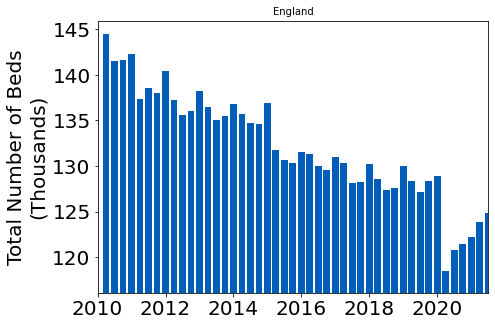

-19552.080148067733
123901


In [5]:
fig, ax1 = plt.subplots(figsize = (7,5))
time = np.arange(2010.25, 2021.75, 0.25)[::-1]

hospital = 0

allBeds = BedsAvail[hospital,:][BedsAvail[hospital,:]!='-']
ax1.set_title(firstNames[hospital],size = 10)
ax1.bar(time[BedsAvail[hospital,:]!='-'], allBeds*1e-3, width = 0.2,
        align='center', alpha=1, color="#005EB8")
#plt.plot(time, allBeds,'r.',lw=2)
ax1.set_ylim(0.98*min(allBeds)*1e-3, 1.01*max(allBeds)*1e-3)
ax1.set_ylabel("Total Number of Beds\n(Thousands)")
ax1.set_xlim(2010, 2021.5)
plt.show()

print(allBeds[0]-allBeds[-1])
print(int(allBeds[1]))

In [6]:
better = 0
worse = 0
same = 0

last_index = -1

totalChange = 0

for i, name in enumerate(firstNames[2:-2]):
    Beds = BedsAvail[firstNames == name]
    Beds = Beds[Beds!='-']
    
    if len(Beds) > 2:
        change = (Beds[0]-Beds[last_index])
        totalChange += change
        if change>50:
            better += 1
        elif change<-50:
            worse += 1
        else:
            same += 1

print(totalChange)

-2174.467896958113


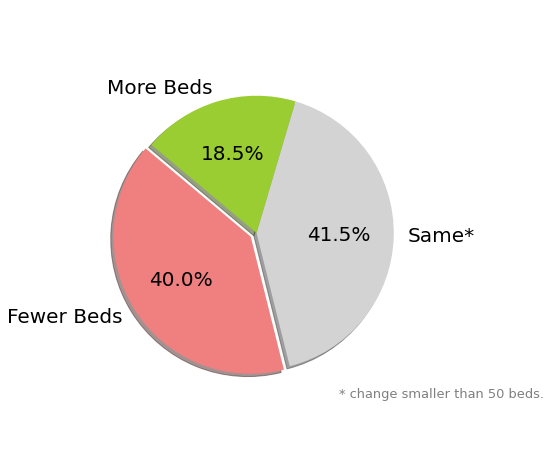

In [7]:
# Data to plot
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rc('font', size=20)

plt.figure(figsize = (7,7))
labels = 'Fewer Beds', 'Same*', 'More Beds'
sizes = [worse, same, better]
colors = ['lightcoral', 'lightgray', 'yellowgreen']
explode = (0.05, 0.0, 0.0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.tight_layout()
plt.annotate("* change smaller than 50 beds.", (0.6, -1.2), size = 13, color = "gray")
plt.savefig("BedsPieChart.png")
plt.show()

#Bahnschrift Light

<h3>Tidy up the data</h3>

In [8]:
# Take out 'nan' value
OutNames = np.delete(firstNames,1)

# Make all names lower case
for i, name in enumerate(OutNames):
    OutNames[i] = name.lower()

# Turn values to integers
BedsOut = np.delete(BedsAvail, 1, axis = 0)
for i in range(len(OutNames)):
    if i != 1:
        for j, val in enumerate(BedsOut[i]):
            if val != '-':
                BedsOut[i][j] = int(val)

In [9]:
np.save("NHSbeds.npy", [OutNames, time, BedsOut])

C:\Users\david\Anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [10]:
firstNames, time, BedsAvail = np.load("NHSbeds.npy", allow_pickle=True)

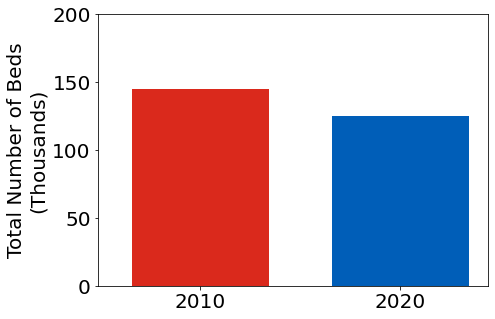

In [11]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rc('font', size=20)

fig, ax1 = plt.subplots(figsize = (7,5))
time = np.arange(2010.25, 2020.75, 0.25)[::-1]

hospital = 0

allBeds = BedsAvail[hospital,:][BedsAvail[hospital,:]!='-']

ax1.bar([time[-1], time[0]], [allBeds[-1]*1e-3, allBeds[0]*1e-3], 
        width = 7, alpha=1,tick_label = [2010, 2020], color = ['#DA291C','#005EB8'])
ax1.set_xlim(2005, 2025)
ax1.set_ylim(0,200)
ax1.set_ylabel("Total Number of Beds\n(Thousands)")
plt.show()
